In [1]:
%matplotlib inline
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, qiime2 as q2
from biom import load_table, Table
from biom.util import biom_open
from skbio import OrdinationResults
from emperor import Emperor, nbinstall; nbinstall()

def load_mf(fn, index='#SampleID'):
    _df = pd.read_csv(fn, sep='\t', dtype='str', na_values=[], keep_default_na=False)
    _df.set_index(index, inplace=True)
    return _df

In [10]:
mf = load_mf('data/11546_20190819-143944.txt', 'sample_name')
# remove blanks
mf = mf.query('empo_1 == "Host-associated"').copy()

Filter the feature table to exclude blanks.

In [25]:
table = q2.Artifact.import_data('FeatureTable[Frequency]', 'data/boland_biom_original.biom')
table.save('data/feature-table.qza')

'data/feature-table.qza'

In [26]:
!qiime feature-table filter-samples \
--i-table data/feature-table.qza \
--m-metadata-file data/11546_20190118-122918.txt \
--p-where "empo_1 == 'Host-associated' and time_point == 'baseline'" \
--o-filtered-table data/feature-table.baseline.noblanks.qza 

Saved FeatureTable[Frequency] to: data/feature-table.baseline.noblanks.qza


In [27]:
!qiime composition add-pseudocount \
--i-table data/feature-table.baseline.noblanks.qza \
--o-composition-table data/feature-table.baseline.noblanks.composition.qza

Saved FeatureTable[Composition] to: data/feature-table.baseline.noblanks.composition.qza


In [28]:
!qiime composition ancom --i-table data/feature-table.baseline.noblanks.composition.qza \
--m-metadata-file data/11546_20190118-122918.txt \
--m-metadata-column has_surgery \
--o-visualization ms.ancom.qzv

Saved Visualization to: ms.ancom.qzv


Next step is to download the summary file from ANCOM and using it to look at the 

In [4]:
ancom_results = pd.read_table('ancom.tsv', index_col=0)

/Users/yoshikivazquezbaeza/miniconda3/envs/qiime2-2019.4/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


In [5]:
ms = q2.Artifact.load('data/feature-table.baseline.noblanks.composition.qza').view(pd.DataFrame)

In [6]:
spectra_metadata = load_table('data/boland_biom_original.biom').metadata_to_dataframe('observation')

In [16]:
spectra_metadata[spectra_metadata.Compound_Name == 'Spectral Match to 1-Amino-2-ethoxybenzene from NIST14']

,Adduct,CAS_Number,Compound_Name,Compound_Source,INCHI,IonMode,LibMZ,LibraryQualityString,Smiles
121.0646;0.3407,M+H-NH3,94702,Spectral Match to 1-Amino-2-ethoxybenzene from...,Isolated,nan,Positive,121.065,Bronze,nan


In [7]:
differential = spectra_metadata.loc[ancom_results[ancom_results["Reject null hypothesis"]].index]

Transform into CLR

In [8]:
from skbio.stats.composition import clr

# ms_df = ms.to_dataframe(True)
ms_df = ms.T.apply(lambda row: clr(row), axis=0)
ms_df = ms_df.loc[differential.index].copy()

# ms_df = ms.filter(differential.index, axis='observation', inplace=False).to_dataframe(True)

In [9]:
mf = mf.loc[ms_df.columns].copy()

names = []
for molecule in ms_df.index:
    row = spectra_metadata.loc[molecule]
    
    if row.Compound_Name == 'nan':
        name = row.name
    else:
        name = row.Compound_Name
    
    # should be copying the CLR transformed data
    mf[name] = ms_df.loc[molecule].copy()
    names.append(name)

long = pd.melt(mf, value_vars=names, id_vars=['has_surgery'], var_name='Molecule', value_name='Intensity',)

In [12]:
long.Molecule.replace({ 
 'Spectral Match to Glycocholic acid from NIST14': 'Glycocholic acid',
 'Spectral Match to Cholic acid from NIST14': 'Cholic acid',
 'Spectral Match to L-Tyrosine from NIST14': 'L-Tyrosine',
 'Spectral Match to L-Glutamic acid from NIST14': 'L-Glutamic acid',
 'Spectral Match to 12-Ketodeoxycholic acid from NIST14': '12-Ketodeoxycholic acid',
 "Massbank:EA019604 Ranitidine|1,1-Ethenediamine, N-(2-(((5-((dimethylamino)methyl)-2-furanyl)methyl)thio)ethyl)-N'-methyl-2-nitro-|1-N'-[2-[[5-(dimethylaminomethyl)furan-2-yl]methylsulfanyl]ethyl]-1-N-methyl-2-nitroethe": 'Ranitidine',
 'Spectral Match to 1-Amino-2-ethoxybenzene from NIST14': '1-Amino-2-ethoxybenzene'
}, inplace=True)

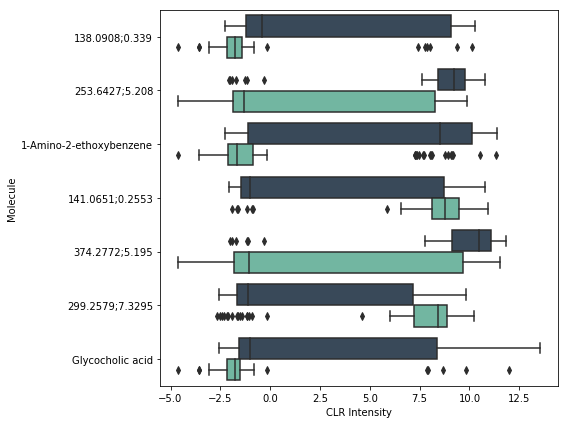

In [84]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(y='Molecule', x='Intensity', hue='has_surgery', data=long.query('Molecule != "nan"'),
            hue_order=['y', 'n'], palette={'n': '#66c2a5', 'y': '#34495e'})

ax.set_xlabel('CLR Intensity')

# legends will be added in Illustrator
ax.legend().set_visible(False)

plt.tight_layout()
plt.savefig('differential-metabolomics.pdf', transparent=True)